
# Predicting the 2022 World Cup Using Machine Learning 



Authors: Omar Mohamed Abdelsalam, and Magdy Abdullah Eissa



# Objective

##### In this project, we use machine learning to predict the results of the 2022 World Cup. We first collect data on all the teams that have participated in the World Cup since its inception. This data includes information on the teams' performances in previous World Cups, as well as their recent form leading up to the current tournament. We then use this data to train a machine learning model that can predict the results of future World Cups.

##### The machine learning model we use is a Logistic Regression model. In this project, we use Logistic Regression to predict the winner of each World Cup match. To do this, we first need to train the model with data from previous World Cups. For each match in the training data, we use the teams' previous World Cup performance, as well as their recent form, to predict the winner. The model then uses this information to learn how to predict the results of future matches.

##### We then use the trained model to predict the results of the 2022 World Cup.


# Data Sets


The three datasets used: 
 FIFA rankings from 1993 to 2022 (courtesy of [Tadhg Fitzgerald](https://www.kaggle.com/tadhgfitzgerald) 
- I used to get the FIFA ranking and points for the teams, which is a monthly changing rank previously shown as a [decent predictor](http://www.sportingintelligence.com/2014/06/20/upsets-giant-killings-adios-bye-bye-fifa-rankings-still-ahead-in-predicting-results-200601/) of team performance
 International Soccer matches from 1872 to 2022 (courtesy of [Mart Jürisoo](https://www.kaggle.com/martj42))
 
- I will use to find out how much the difference in point, ranks and the current rank of the team affects the outocme of a match
 FIFA World Cup 2022 data set (courtesy of [Nuggs](https://www.kaggle.com/ahmedelnaggar))
 
- I will use to get the upcoming matches, I had to personally update this dataset.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv('/Users/abdel/World/fifa_ranking.csv') # Make sure after you download the datasets you make sure the Path is correct!
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('/Users/abdel/World/results.csv') # Make sure after you download the datasets you make sure the Path is correct!
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv("/Users/abdel/World/New World Cup 2022 Dataset.csv") # Make sure after you download the datasets you make sure the Path is correct!
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

# Extracting the Features

The features we extracted were: 
- point and rank differences
- if the game was for some stakes, because my naive view was that typically friendly matches are harder to predict (TODO differentiate the WC matches from the rest)
- how many days the different teams were able to rest but this turned out to be not important enough to be worth the hassle
- include the participant countries as a one hot vector but that did not appear to be a strong predictor either

In [2]:
# ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# ranks joining
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [3]:
# Generating Features
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

# Modeling
#### Logistic Regression was used

C:\Users\abdel\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


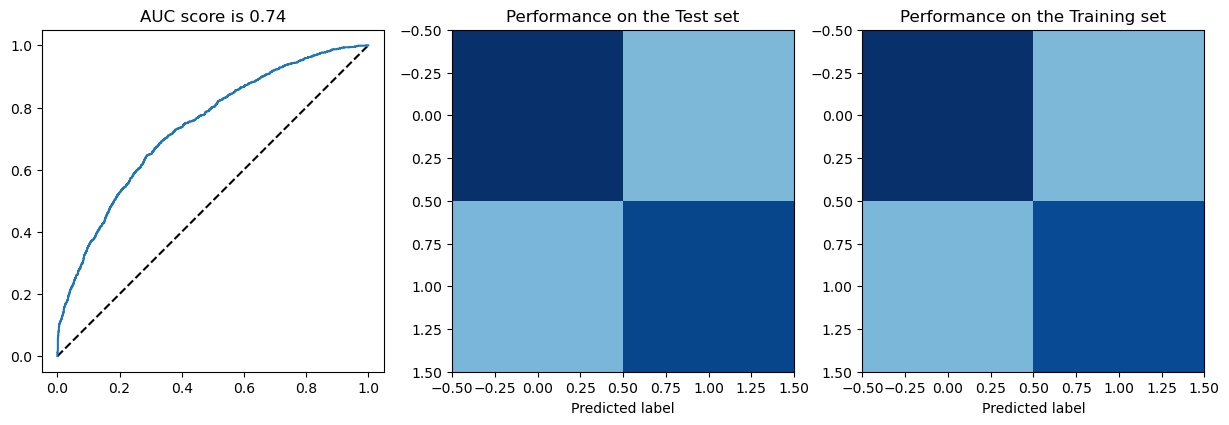

In [4]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Stakes distribution in the wrong predictions
True     0.552075
False    0.447925
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.623685
False    0.376315
Name: is_stake, dtype: float64


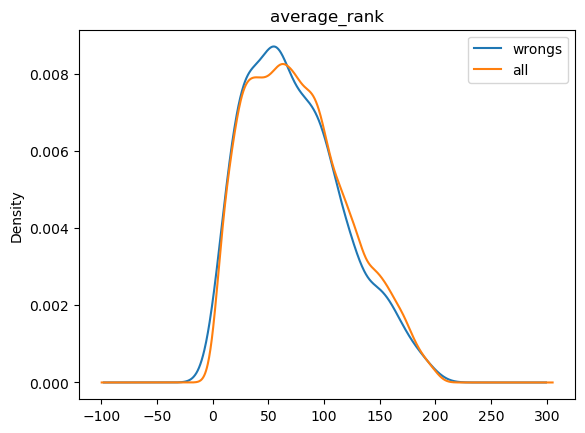

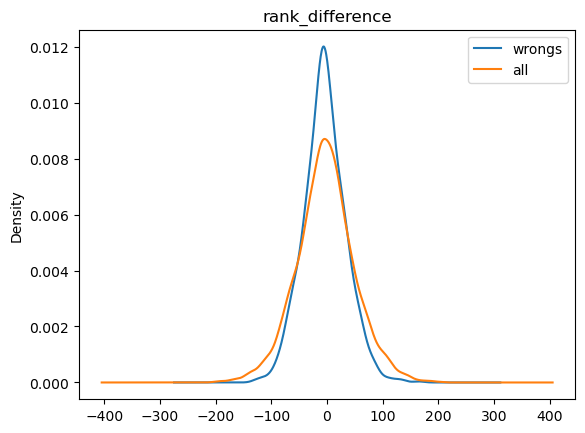

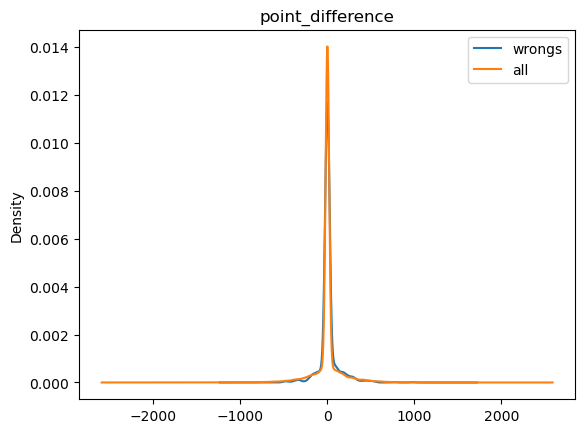

In [5]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read 
- we predict worse for closer ranks
- lower ranks in general
- and somewhat for matches with no stakes (Friendly here)

Luckily, this implies that for the world cup our predicitons may be somewhat even better

# World Cup simulation

## Group rounds

In [6]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [7]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group D:___
France vs. Australia: France wins with 0.63
___Starting group B:___
England vs. USA: England wins with 0.56
___Starting group E:___
Japan vs. Spain: Spain wins with 0.81
___Starting group F:___
Morocco vs. Croatia: Croatia wins with 0.63
___Starting group C:___
Argentina vs. Poland: Draw
___Starting group A:___
Senegal vs. Netherlands: Netherlands wins with 0.64
___Starting group G:___
Switzerland vs. Brazil: Brazil wins with 0.56
___Starting group H:___
South Korea vs. Portugal: Portugal wins with 0.84


## Single-elimination rounds

In [8]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherlands vs. USA: Netherlands wins with probability 0.55
Argentina vs. Australia: Argentina wins with probability 0.65
Spain vs. Morocco: Spain wins with probability 0.64
Brazil vs. South Korea: Brazil wins with probability 0.71
Senegal vs. England: England wins with probability 0.63
Poland vs. France: France wins with probability 0.53
Japan vs. Croatia: Croatia wins with probability 0.73
Switzerland vs. Portugal: Portugal wins with probability 0.57


___Starting of the quarterfinal___
Netherlands vs. Argentina: Argentina wins with probability 0.55
Spain vs. Brazil: Brazil wins with probability 0.56
England vs. France: France wins with probability 0.53
Croatia vs. Portugal: Portugal wins with probability 0.69


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.54
France vs. Portugal: Portugal wins with probability 0.58


___Starting of the final___
Brazil vs. Portugal: Portugal wins with probability 0.51




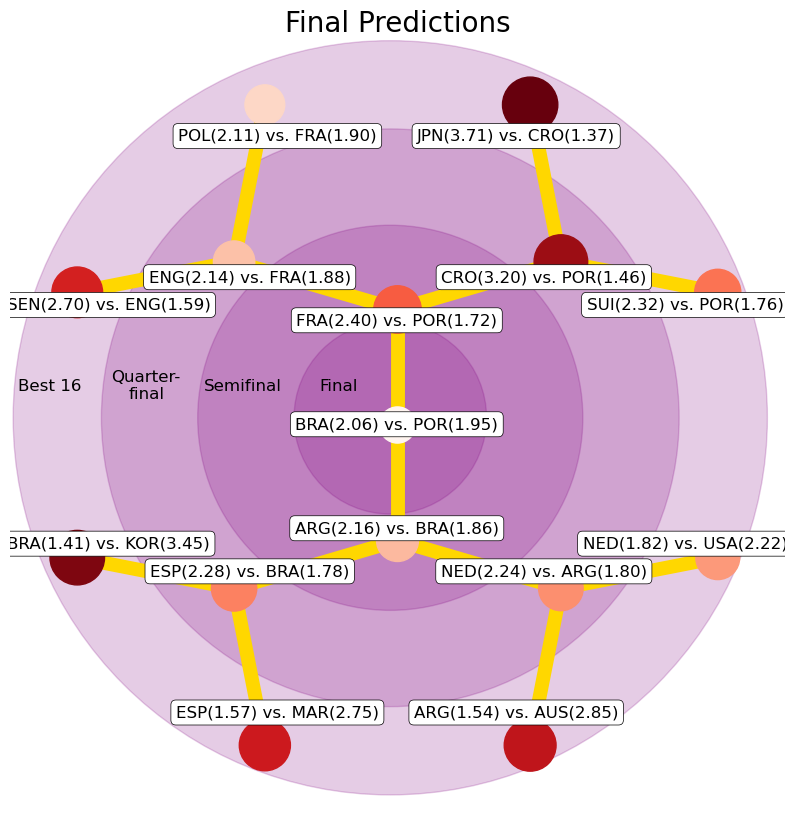

In [9]:
#Visualization

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = nx.nx_agraph.graphviz_layout(G,prog='twopi', args='')

centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='purple', # changed the colors of the outer cirlces
                          alpha=0.2)) for cp, c in circle_positions]

# first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='gold', #changes the colors of the connection between the circles
        width=10,
        with_labels=False)

# custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='black',  #changes the color of the bracket text
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Final Predictions', fontsize=20)
plt.show()


# Final Prediction Winner : Portugal!

### Appreciation
I would like to thank Magdy Abdullah Eissa. Thank you for your time, wisdom, and guidance. You have helped me immensely in my professional and personal development, and I am truly grateful. I would not be where I am today without your support. Thank you for being an amazing mentor!


## Credit
Dr. James Bond (https://www.kaggle.com/agostontorok) 
